In [1]:
import tensorflow as tf
from functions import *
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import numpy as np
import pickle


2024-04-09 05:04:23.651971: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 05:04:23.971513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 05:04:24.961191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import gc
gc.collect()


22

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


2024-04-09 05:04:28.163223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 05:04:28.361091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 05:04:28.361233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.keras.backend import clear_session
clear_session()

In [5]:
def custom_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    reg = regularizers.l2(0.01)
    regularization = tf.reduce_sum(reg(y_pred)) * tf.reduce_max(y_pred)
    loss = bce + regularization
    return loss



from tensorflow.keras.models import load_model

model = load_model('model.keras', custom_objects={'custom_loss': custom_loss})

2024-04-09 05:04:28.452574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 05:04:28.452754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 05:04:28.452821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# if testing_set_dumped.pkl is present load it else create it


if os.path.isfile('dataset_pickle_dumps/testing_set_dumped.pkl'):
    with open('dataset_pickle_dumps/testing_set_dumped.pkl', 'rb') as file:
        tensors_test, labels_test = pickle.load(file)
        dataset_test = tf.data.Dataset.from_tensor_slices((tensors_test, labels_test))
        dataset_test = dataset_test.shuffle(buffer_size=len(tensors_test)).batch(32)

    print("Testing set loaded from pickle dump")

else:

    with open('test_preprocessed.txt', 'r') as file:
        data = file.readlines()
        
    file_names_test = []
    labels_test = []

    subset_size = 30000

    for line in data:
        if subset_size == 0:
            break
        subset_size -= 1
        file_name, label = line.split()
        labels_test.append(int(label))
        file_names_test.append(file_name)

    tensors_test = []

    directory_path = 'LA/ASVspoof2019_LA_eval/flac'

    ctr = 0 

    for file_name in file_names_test:
        ctr += 1
        if ctr % 100 == 0:
            print(f"PROGRESS: {ctr}/{len(file_names_test)}")
            # print a progress bar
    

        file_path = os.path.join(directory_path, file_name)
        signal, sample_rate = read_flac_file(file_path)
        lfcc_features = extract_lfcc(signal, sample_rate)
        tensor = tf.convert_to_tensor(lfcc_features)
        tensor = tf.expand_dims(tensor, axis=0)
        tensors_test.append(tensor[0])


    labels_test = tf.convert_to_tensor(labels_test)

    dataset_test = tf.data.Dataset.from_tensor_slices((tensors_test, labels_test))

    dataset_test = dataset_test.shuffle(buffer_size=len(tensors_test)).batch(32)

    with open('dataset_pickle_dumps/testing_set_dumped.pkl', 'wb') as file:
            # convert the dataset to a list of tuples and dump it
            pickle.dump((tensors_test, labels_test), file)

print("Testing set loaded")
print("SIZE OF TESTING SET: ", len(dataset_test))
    


PROGRESS: 100/30000
PROGRESS: 200/30000
PROGRESS: 300/30000
PROGRESS: 400/30000
PROGRESS: 500/30000
PROGRESS: 600/30000
PROGRESS: 700/30000
PROGRESS: 800/30000
PROGRESS: 900/30000
PROGRESS: 1000/30000
PROGRESS: 1100/30000
PROGRESS: 1200/30000
PROGRESS: 1300/30000
PROGRESS: 1400/30000
PROGRESS: 1500/30000
PROGRESS: 1600/30000
PROGRESS: 1700/30000
PROGRESS: 1800/30000
PROGRESS: 1900/30000
PROGRESS: 2000/30000
PROGRESS: 2100/30000
PROGRESS: 2200/30000
PROGRESS: 2300/30000
PROGRESS: 2400/30000
PROGRESS: 2500/30000
PROGRESS: 2600/30000
PROGRESS: 2700/30000
PROGRESS: 2800/30000
PROGRESS: 2900/30000
PROGRESS: 3000/30000
PROGRESS: 3100/30000
PROGRESS: 3200/30000
PROGRESS: 3300/30000
PROGRESS: 3400/30000
PROGRESS: 3500/30000
PROGRESS: 3600/30000
PROGRESS: 3700/30000
PROGRESS: 3800/30000
PROGRESS: 3900/30000
PROGRESS: 4000/30000
PROGRESS: 4100/30000
PROGRESS: 4200/30000
PROGRESS: 4300/30000
PROGRESS: 4400/30000
PROGRESS: 4500/30000
PROGRESS: 4600/30000
PROGRESS: 4700/30000
PROGRESS: 4800/30000
P

In [ ]:
from tensorflow.keras import losses , regularizers


model.evaluate(dataset_test)

predictions = model.predict(dataset_test , verbose=1)

2024-04-09 04:59:08.297813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-09 04:59:08.355394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2227/2227 [==============================] - 6s 3ms/step


In [ ]:
predictions = model.predict(dataset_test)


2227/2227 [==============================] - 6s 3ms/step


In [ ]:
import numpy as np

print(np.max(predictions))
print(np.min(predictions))

0.97367775
0.0033051637


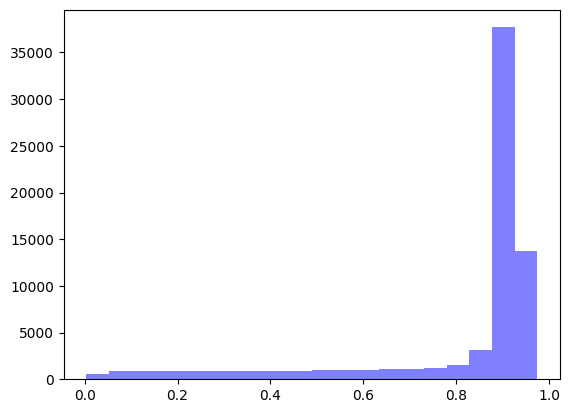

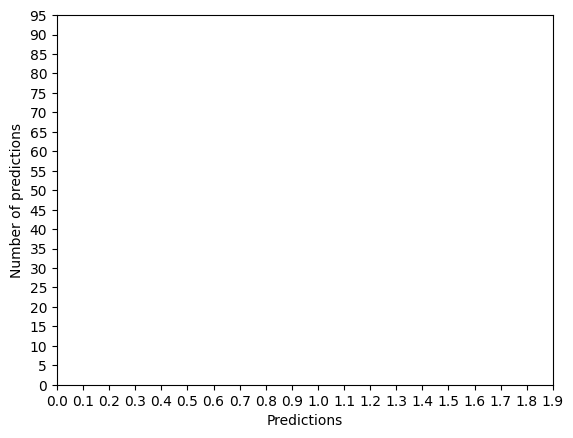

In [ ]:
import matplotlib.pyplot as plt

num_bins = 20

n, bins, patches = plt.hist(predictions, num_bins, facecolor='blue', alpha=0.5)
plt.show()


plt.xticks(np.arange(0, 2, 0.1))
plt.yticks(np.arange(0, 100, 5))

plt.xlabel('Predictions')
plt.ylabel('Number of predictions')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d


def accuracy_based_on_thresholds(actual_labels, threshold):
    predicted_labels = np.where(predictions > threshold, 1, 0)
    accuracy_overall = np.mean(actual_labels == predicted_labels)
    accuracy_of_predicting_bonafide = np.mean(actual_labels[actual_labels == 0] == predicted_labels[actual_labels == 0])
    accuracy_of_predicting_spoof = np.mean(actual_labels[actual_labels == 1] == predicted_labels[actual_labels == 1])
    fpr, tpr, thresholds = roc_curve(actual_labels, predictions)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return accuracy_overall, accuracy_of_predicting_bonafide, accuracy_of_predicting_spoof, eer



In [ ]:



thresholds = np.linspace(0, 2, 200)
accuracies = []
bonafide_accuracies = []
spoof_accuracies = []
eers = []

for threshold in thresholds:
    accuracy, bonafide_accuracy, spoof_accuracy, eer = accuracy_based_on_thresholds(labels_test, threshold)
    accuracies.append(accuracy)
    bonafide_accuracies.append(bonafide_accuracy)
    spoof_accuracies.append(spoof_accuracy)
    eers.append(eer)



NameError: name 'labels_test' is not defined

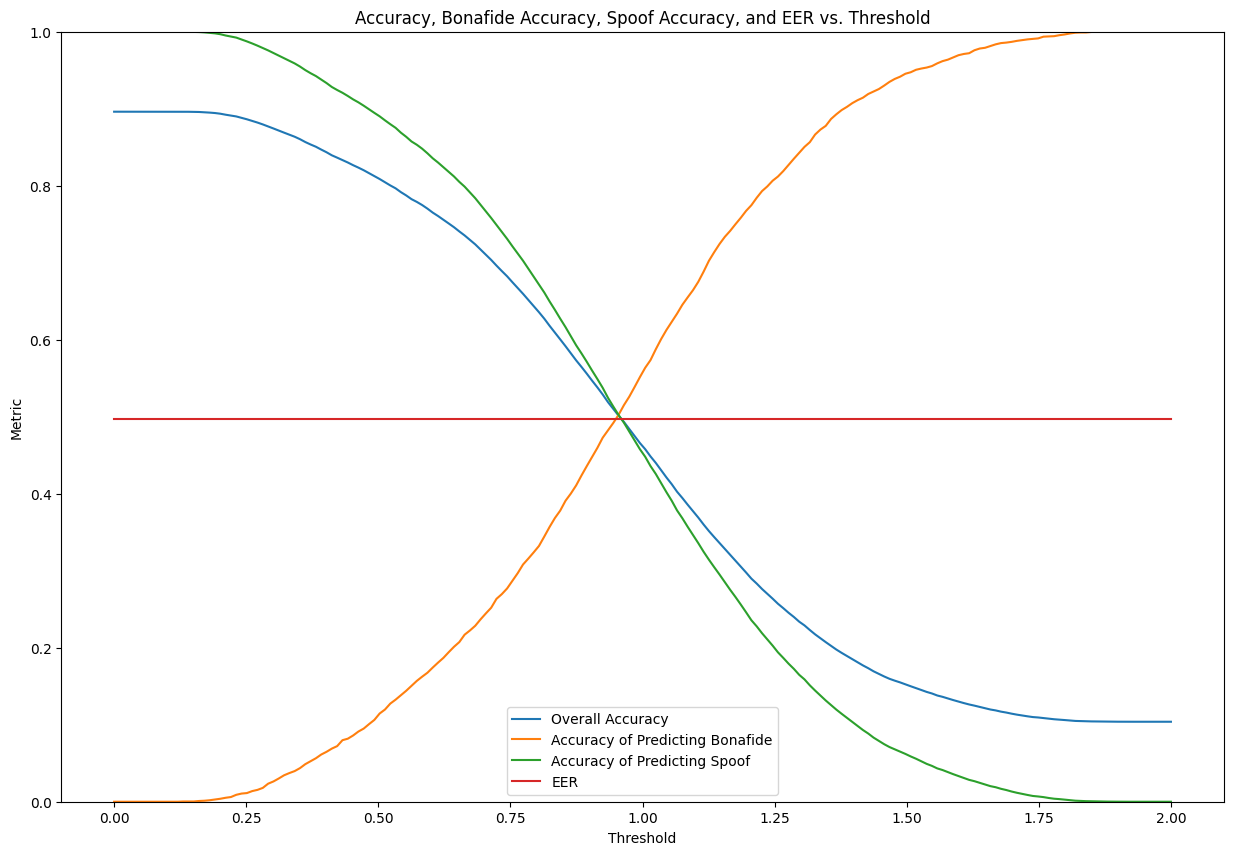

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(thresholds, accuracies, label='Overall Accuracy')
plt.plot(thresholds, bonafide_accuracies, label='Accuracy of Predicting Bonafide')
plt.plot(thresholds, spoof_accuracies, label='Accuracy of Predicting Spoof')
plt.plot(thresholds, eers, label='EER')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.ylim([0, 1])
plt.title('Accuracy, Bonafide Accuracy, Spoof Accuracy, and EER vs. Threshold')
plt.legend()
plt.show()


In [ ]:
# EER , t-DCF and Accuracy  

from sklearn.metrics import confusion_matrix


fpr, tpr, thresholds = roc_curve(labels_test, predictions)
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

# t-DCF

def tDCF_asvspoof19(scores, labels, Pspoof=0.05, costModel=[1, 10, 1]):
    CM = confusion_matrix(labels, scores > 0.5)
    Ptar = np.sum(labels == 1) / len(labels)
    Pnon = 1 - Ptar
    
    # Handle the case when Ptar is zero
    if Ptar == 0:
        Cmiss = 0  # Set Cmiss to zero or any other appropriate value
    else:
        Cmiss = costModel[0] * Pnon * (1 - CM[1, 1]) / Ptar
        
    Cfa = costModel[1] * Ptar * CM[0, 1] / Pnon
    Cspoof = costModel[2] * Pspoof
    tDCF = Cmiss + Cfa - Cspoof
    return tDCF


tDCF = tDCF_asvspoof19(predictions, labels_test)
print('t-DCF:', tDCF)

print('EER%:', eer*100)

t-DCF: 235952.78251945938
EER%: 49.75078113376187


In [ ]:
from sklearn.metrics import accuracy_score

# threshold which gives EER 

threshold = thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]
print('Threshold:', threshold)

accuracy = accuracy_score(labels_test, predictions > threshold)

print('Accuracy:', accuracy)

Threshold: 0.95456105
Accuracy: 0.5024666666666666


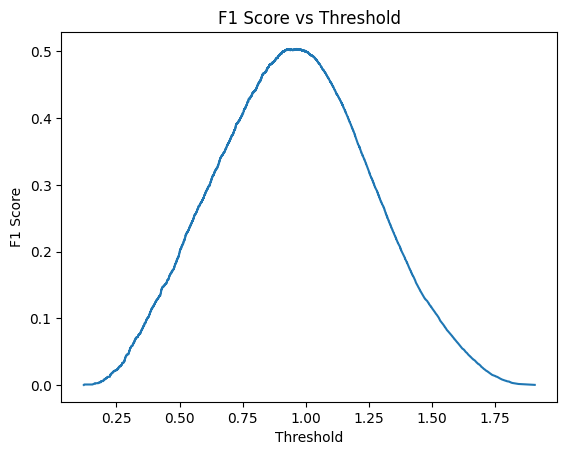

In [ ]:
# bonafde : 0
# spoof : 1

# plot F1 scores 

f1_score = 2 * (tpr * (1 - fpr)) / (tpr + (1 - fpr))

import matplotlib.pyplot as plt

plt.plot(thresholds, f1_score)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
20
plt.show()

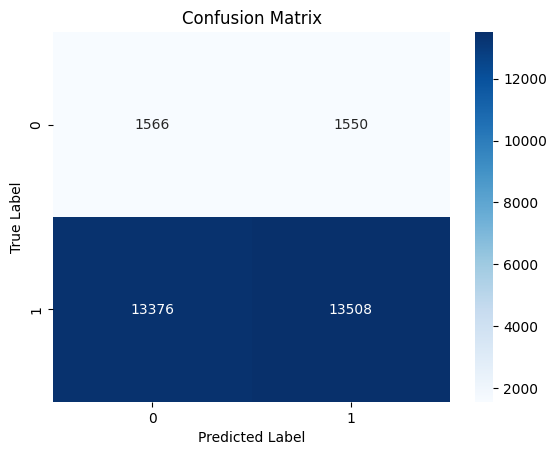

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = confusion_matrix(labels_test, predictions > threshold)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')

plt.ylabel('True Label')

plt.title('Confusion Matrix')

plt.show()

In [ ]:
import pandas as pd
import datetime
import os

if os.path.exists('results.csv'):
    df = pd.read_csv('results.csv')
else:
    df = pd.DataFrame(columns=["Sno", "Time", "T", "F", "test_SampleSize", "n_epochs", "tDCF", "EER", "Accuracy", "F1_scores", "True_positive", "True_negative", "False_positive", "False_negative"])
    

acc = accuracy_based_on_thresholds(labels_test, threshold)

accuracy_bonafide_atEER = acc[1]

accuracy_spoof_atEER = acc[2]

f1_scores = f1_score[np.nanargmin(np.abs(fpr - (1 - tpr)))]

# make dictionary for better understanding 

f1_scores = {
    "bonafide": f1_score[np.nanargmin(np.abs(fpr - (1 - tpr)))],
    "spoof": f1_score[np.nanargmin(np.abs(fpr - (1 - tpr)))]
}

new_row = pd.DataFrame([{"Sno": len(df), "Time": str(datetime.datetime.now()), "T": hp.T, "F": hp.F, "test_SampleSize": len(file_names_test), "n_epochs": hp.n_epochs_training, "tDCF": tDCF, "EER": eer, "Accuracy": accuracy, "F1_scores": f1_scores, "True_positive": confusion_matrix[1, 1], "True_negative": confusion_matrix[0, 0], "False_positive": confusion_matrix[0, 1], "False_negative": confusion_matrix[1, 0] , "accuracy_bonafide": accuracy_bonafide_atEER, "accuracy_spoofed": accuracy_spoof_atEER , "threshold": threshold}])

df = pd.concat([df, new_row], ignore_index=True)

df.to_csv('results.csv', index=False)


In [ ]:
pd.set_option('display.max_rows', None)


pd.set_option('display.max_colwidth', None)


df

,Sno,Time,T,F,test_SampleSize,n_epochs,tDCF,EER,Accuracy,F1_scores,True_positive,True_negative,False_positive,False_negative,threshold,accuracy_bonafide,accuracy_spoofed
0,0,2024-03-15 17:25:30.588737,50,50,10000,10,73690.907841,0.496720,0.774700,[0.08252149 0.912298 ],7571,176,891,1362,-,-,NaN
1,1,2024-03-15 17:25:34.698020,50,50,10000,10,73690.907841,0.496720,0.774700,[0.08252149 0.912298 ],7571,176,891,1362,-,-,NaN
2,2,2024-03-15 18:37:03.356791,500,10,10000,20,78829.036310,0.495802,0.812500,[0.03843074 0.93595008],8011,114,953,922,-,-,NaN
3,3,2024-03-15 18:55:01.670302,500,10,40000,20,322180.825000,0.502163,0.814800,[0.03288005 0.93652845],32215,377,3783,3625,-,-,NaN
4,4,2024-03-15 19:47:36.964071,500,10,3000,20,22304.716917,0.485294,0.813333,[0.07223476 0.92603923],2389,51,289,271,-,-,NaN
5,5,2024-03-15 19:58:43.600425,500,10,71237,20,-0.050000,0.496087,0.816893,[0.04946704 0.93084157],57419,774,6581,6463,-,-,NaN
6,6,2024-03-15 19:59:42.742981,500,10,71237,20,-0.050000,0.496087,0.816893,[0.10608553 0.89799972],57419,774,6581,6463,-,-,NaN
7,7,2024-03-15 20:00:58.593009,500,10,71237,20,-0.050000,0.496087,0.816893,[0.10608553 0.89799972],57419,774,6581,6463,-,-,NaN
8,8,2024-03-15 20:03:19.379623,500,10,71237,20,-0.050000,0.496087,0.816893,[0.10608553 0.89799972],57419,774,6581,6463,-,-,NaN
9,9,2024-03-15 20:04:41.151050,500,10,71237,20,-0.050000,0.496087,0.816893,[0.10608553 0.89799972],57419,774,6581,6463,-,-,NaN
